# Regression

Simply fit some noisy data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neighpy import NASearcher, NAAppraiser

Create some noisy data.  This will be a sum of cosines with a small amount of Gaussian noise.

In [2]:
rng = np.random.default_rng(42)

In [35]:
domain = (0, 2 * np.pi)
n_x = 50
x = np.linspace(*domain, num=n_x)
xm = np.linspace(*domain, num=n_x // 2)

def cosine(m, mask=True):
    _x = xm if mask else x
    _x = np.stack([i * _x for i in range(1, m.size + 1)])
    return np.sum(m[:, np.newaxis] * np.cos(_x), axis=0)

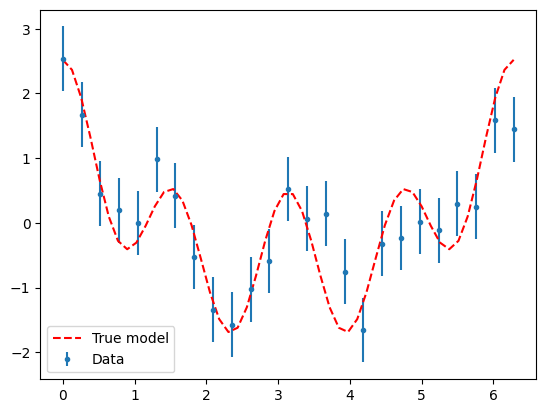

In [43]:
true_parameters = np.array([1, 0.5, 0.02, 1])
data = cosine(true_parameters)
sigma = 0.5
Cdinv = (1 / sigma ** 2) * np.eye(data.size)
data += rng.normal(loc=0, scale=sigma, size=data.shape)
plt.errorbar(xm, data, yerr=sigma, fmt=".", label="Data")
plt.plot(x, cosine(true_parameters, mask=False), "r--", label="True model")
plt.legend()

The objective function will be to minimise the error-weighted squared data misfit
$$\Phi(\mathbf{m}) = (\mathbf{d} - \mathbf{Gm})^T C_d^{-1} (\mathbf{d} - \mathbf{Gm})$$
where $\mathbf{G}$ represents the basis of cosine functions (i.e. we are assuming we understand the physics perfectly).

In [37]:
def objective(m):
    prediction = cosine(m)
    residual = data - prediction
    return residual @ (Cdinv @ residual)


## NA Direct Seach Phase

In [38]:
searcher = NASearcher(
    objective=objective,
    ns=100,
    nr=10,
    ni=1000,
    n=20,
    bounds=[(0, 2)] * 4,
)

searcher.run()

NAI - Initial Random Search


NAI - Optimisation Loop:   0%|          | 0/20 [00:00<?, ?it/s]

NAI - Optimisation Loop: 100%|██████████| 20/20 [00:00<00:00, 31.21it/s]


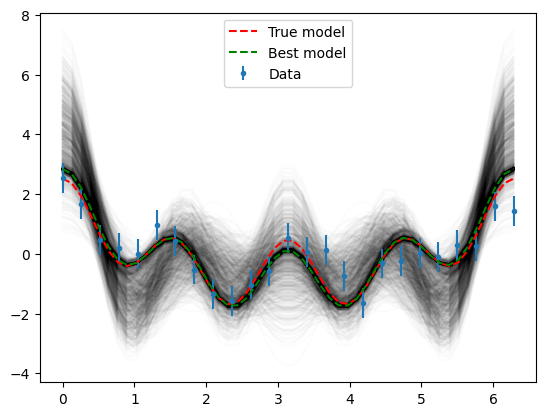

In [44]:
best = searcher.samples[np.argmin(searcher.objectives)]

plt.plot(x, np.apply_along_axis(cosine, 1, searcher.samples, mask=False).T, "k", alpha=0.01)
plt.errorbar(xm, data, yerr=sigma, fmt=".", label="Data")
plt.plot(x, cosine(true_parameters, mask=False), "r--", label="True model")
plt.plot(x, cosine(best, mask=False), "g--", label="Best model")
plt.legend()

## NA Appraisal Phase

Obtain independent samples of the posterior probability density function, which is approximated from the samples obtained in the direct search phase.

A technicality here is that in the previous phase we looked to *minimise* the objective function i.e. minimise the predictive data misfit.  In this phase we look to *maximise* the posterior.  Under the hood, `NAAppraiser` expects the objective function values given to it to be the log of the posterior pdf, unless we tell it otherwise. Our objective function above is the *negative log posterior*
$$p(\mathbf{m}|\mathbf{d}) \propto e^{-\Phi(\mathbf{m})}$$
so we need to supply `NAAppraiser` with `-searcher.objectives`.

Note that the nomrmalisation constant is ignored because the sampler only compares ratios of posterior densities.

In [45]:
appraiser = NAAppraiser(
    searcher.samples,
    -searcher.objectives,
    bounds=searcher.bounds,
    n_resample=10000,
    n_walkers=10,
)

appraiser.run()

NAII - Random Walk:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/u1138256/Documents/napy/neighpy/appraise.py:150: RuntimeWarning: invalid value encountered in log
  if np.log(r) < np.log(Pxpi) - np.log(Pmax):  # eqn (24) Sambridge 1999(II)
/Users/u1138256/Documents/napy/neighpy/appraise.py:150: RuntimeWarning: invalid value encountered in log
  if np.log(r) < np.log(Pxpi) - np.log(Pmax):  # eqn (24) Sambridge 1999(II)
/Users/u1138256/Documents/napy/neighpy/appraise.py:150: RuntimeWarning: invalid value encountered in log
  if np.log(r) < np.log(Pxpi) - np.log(Pmax):  # eqn (24) Sambridge 1999(II)
/Users/u1138256/Documents/napy/neighpy/appraise.py:150: RuntimeWarning: invalid value encountered in log
  if np.log(r) < np.log(Pxpi) - np.log(Pmax):  # eqn (24) Sambridge 1999(II)
NAII - Random Walk:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/u1138256/Documents/napy/neighpy/appraise.py:150: RuntimeWarning: invalid value encountered in log
  if np.log(r) < np.log(Pxpi) - np.log(Pmax):  

KeyboardInterrupt: 

In [46]:
plt.plot(x, np.apply_along_axis(cosine, 1, appraiser.samples, mask=False).T, "k", alpha=0.01)
plt.plot(x, cosine(appraiser.mean, mask=False), "b--", label="Mean model")
plt.errorbar(xm, data, yerr=sigma, fmt=".", label="Data")
plt.plot(x, cosine(true_parameters, mask=False), "r--", label="True model")
plt.plot(x, cosine(best, mask=False), "g--", label="Best model")
plt.legend()

AttributeError: 'NAAppraiser' object has no attribute 'samples'